# Train a Model via API

This notebook demonstrates how to train, test and infer the FastFlow model via Anomalib API. Compared to the CLI entrypoints such as \`tools/\<train, test, inference>.py, the API offers more flexibility such as modifying the existing model or designing custom approaches.


## Setting up the Dataset Directory

This cell is to ensure we change the directory to have access to the datasets.


In [3]:
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = Path.cwd().parents[1] / "datasets" / "pv"
print(dataset_root)

/home/shiva/Documents/solar-anomalib/datasets/pv


## Imports


In [4]:
import numpy as np
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import Resize, Compose, Lambda, ToTensor, ToPILImage
import torchvision.transforms.v2.functional as F

from anomalib.data import PredictDataset, Folder
from anomalib.engine import Engine
from anomalib.models import Fastflow
from anomalib.utils.post_processing import superimpose_anomaly_map
from anomalib import TaskType

## Data Module

To train the model end-to-end, we do need to have a dataset. In our [previous notebooks](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules), we demonstrate how to initialize benchmark- and custom datasets. In this tutorial, we will use MVTec AD DataModule. We assume that `datasets` directory is created in the `anomalib` root directory and `MVTec` dataset is located in `datasets` directory.

Before creating the dataset, let's define the task type that we will be working on. In this notebook, we will be working on a segmentation task. Therefore the `task` variable would be:


In [6]:
task = TaskType.SEGMENTATION

In [7]:
# transforms
IMAGE_SIZE = (256, 256)
CONTRAST_FACTOR = 1.2
#BRIGHTNESS_FACTOR = 0.5
GAMMA = 0.5
SATURATION_FACTOR = 1.2
transform = Compose([
    ToTensor(),
    Resize(IMAGE_SIZE, antialias=True),
    Lambda(lambda img: F.adjust_contrast_image(img, CONTRAST_FACTOR)),
    #Lambda(lambda img: F.equalize(img)),
    #Lambda(lambda img: F.adjust_brightness(img, brightness_factor)),
    Lambda(lambda img: F.adjust_saturation(img,SATURATION_FACTOR)),
    Lambda(lambda img: F.adjust_gamma(img, GAMMA)),
    #ConvertImageDtype(torch.uint8),

])

/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [8]:
datamodule = Folder(
    name="pv",
    root=dataset_root,
    normal_dir="train/good",
    abnormal_dir="test/bad",
    transform=transform,
    task=TaskType.CLASSIFICATION,
    image_size=(256, 256),
)

## FastFlow Model

Now that we have created the MVTec datamodule, we could create the FastFlow model. We could start with printing its docstring.


In [14]:
Fastflow

anomalib.models.image.fastflow.lightning_model.Fastflow

In [15]:
model = Fastflow(backbone="resnet18", pre_trained=True, flow_steps=8)
engine = Engine()
predictions = engine.predict(
    datamodule=datamodule,
    model=model,
    ckpt_path="/home/shiva/Documents/code/anomalib/notebooks/200_models/results/Fastflow/MVTec/bottle/v0/checkpoints/epoch=13-step=98.ckpt",
)     
print(predictions)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
Restoring states from the checkpoint path at /home/shiva/Documents/code/anomalib/notebooks/200_models/results/Fastflow/MVTec/bottle/v0/checkpoints/epoch=13-step=98.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/shiva/Documents/code/anomalib/notebooks/200_models/results/Fastflow/MVTec/bottle/v0/checkpoints/epoch=13-step=98.ckpt


Output()

IsADirectoryError: Caught IsADirectoryError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/shiva/Documents/code/anomalib/src/anomalib/data/base/dataset.py", line 180, in __getitem__
    else read_mask(mask_path, as_tensor=True)
  File "/home/shiva/Documents/code/anomalib/src/anomalib/data/utils/image.py", line 374, in read_mask
    image = Image.open(path).convert("L")
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/PIL/Image.py", line 3277, in open
    fp = builtins.open(filename, "rb")
IsADirectoryError: [Errno 21] Is a directory: '/home/shiva/Documents/solar-anomalib/notebooks/200_models'


In [16]:
test_result = engine.test(datamodule=datamodule, model=model)


F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/multiprocessing/connection.py", line 177, in close
    reader_close()
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    self._close()
  File "/home/shiva/minic

IsADirectoryError: Caught IsADirectoryError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/shiva/Documents/code/anomalib/src/anomalib/data/base/dataset.py", line 180, in __getitem__
    else read_mask(mask_path, as_tensor=True)
  File "/home/shiva/Documents/code/anomalib/src/anomalib/data/utils/image.py", line 374, in read_mask
    image = Image.open(path).convert("L")
  File "/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/PIL/Image.py", line 3277, in open
    fp = builtins.open(filename, "rb")
IsADirectoryError: [Errno 21] Is a directory: '/home/shiva/Documents/solar-anomalib/notebooks/200_models'


## Inference

Since we have a trained model, we could infer the model on an individual image or folder of images. Anomalib has an `PredictDataset` to let you create an inference dataset. So let's try it.


In [ ]:
print(dataset_root)

/home/shiva/Documents/solar-anomalib/datasets/pv


In [ ]:
#inference_dataset = PredictDataset(path=dataset_root / "test/good/img_0_processed.png")
inference_dataset = PredictDataset(path=dataset_root / "test/bad/110M90500098_DEFECTUEUX__panel_0011__Cam-5_3540.jpg")

inference_dataloader = DataLoader(dataset=inference_dataset)

In [ ]:
for batch in inference_dataloader:
    print(batch.keys())  # Inspect the keys of the dictionary
    break

dict_keys(['image', 'image_path'])


In [ ]:
for batch in inference_dataloader:
    inputs = batch["image"]
    print(inputs.shape)


torch.Size([1, 3, 1536, 2048])


We could utilize `Trainer`'s `predict` method to infer, and get the outputs to visualize


In [ ]:
predictions = engine.predict(model=model, dataloaders=inference_dataloader)[0]

ckpt_path is not provided. Model weights will not be loaded.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/home/shiva/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


`predictions` contain image, anomaly maps, predicted scores, labels and masks. These are all stored in a dictionary. We could check this by printing the `prediction` keys.


In [ ]:
print(
    f'Image Shape: {predictions["image"].shape},\n'
    'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    'Predicted Mask Shape: {predictions["pred_masks"].shape}',
)

Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: {predictions["anomaly_maps"].shape}, 
Predicted Mask Shape: {predictions["pred_masks"].shape}


## Visualization


To properly visualize the predictions, we will need to perform some post-processing operations.

Let's first show the input image. To do so, we will use `image_path` key from the `predictions` dictionary, and read the image from path. Note that `predictions` dictionary already contains `image`. However, this is the normalized image with pixel values between 0 and 1. We will use the original image to visualize the input image.

In [ ]:
image_path = predictions["image_path"][0]
image_size = predictions["image"].shape[-2:]
image = np.array(Image.open(image_path).resize(image_size))

The first output of the predictions is the anomaly map. As can be seen above, it's also a torch tensor and of size `torch.Size([1, 1, 256, 256])`. We therefore need to convert it to numpy and squeeze the dimensions to make it `256x256` output to visualize.


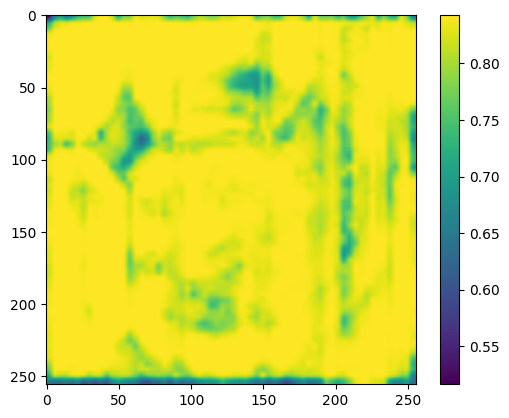

In [ ]:
%matplotlib inline
anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)
plt.colorbar()  # Optional: adds a colorbar to the side of the image
plt.show()

We could superimpose (overlay) the anomaly map on top of the original image to get a heat map. Anomalib has a built-in function to achieve this. Let's try it.


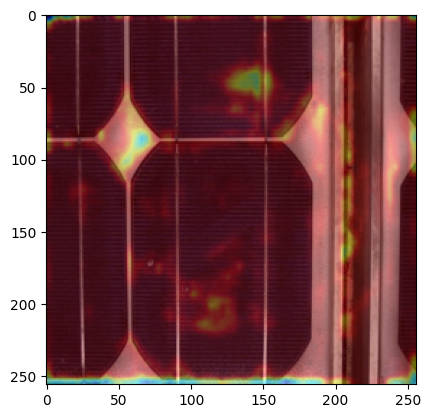

In [ ]:
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)

`predictions` also contains prediction scores and labels.


In [ ]:
pred_score = predictions["pred_scores"][0]
pred_labels = predictions["pred_labels"][0]
print(pred_score, pred_labels)

tensor(0.7385) tensor(True)


The last part of the predictions is the mask that is predicted by the model. This is a boolean mask containing True/False for the abnormal/normal pixels, respectively.


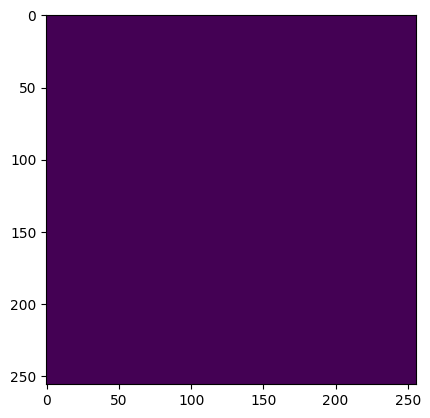

In [ ]:
pred_masks = predictions["pred_masks"][0].squeeze().cpu().numpy()
plt.imshow(pred_masks)

That wraps it! In this notebook, we show how we could train, test and finally infer a FastFlow model using Anomalib API.
